In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


## Открытие и преобразование таблицы

In [17]:
df = pd.read_csv('lag.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
print(df.shape)
df.sample(2)

(1756857, 3)


,Timestamp,Close Candle,Ticker Full Name
1175828,2021-11-15 08:25:00,4696.5,E-MINI S&P 500 FUTURES
1592084,2021-05-12 23:18:00,16894.0,FTSE CHINA A50 INDEX FUTURES


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1756857 entries, 0 to 1756856
Data columns (total 3 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Timestamp         datetime64[ns]
 1   Close Candle      float64       
 2   Ticker Full Name  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 40.2+ MB


Напечатаем нормализированное колебание акций.

<AxesSubplot:xlabel='Timestamp'>

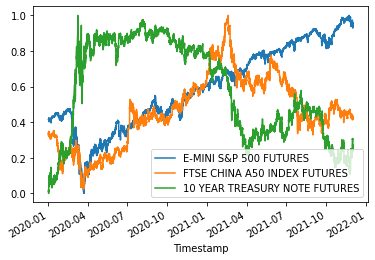

In [19]:

new_df = pd.DataFrame(df['Timestamp'].unique(), columns = ['Timestamp'])
for name in ['E-MINI S&P 500 FUTURES',
       'FTSE CHINA A50 INDEX FUTURES','10 YEAR TREASURY NOTE FUTURES']:
    t=df[df['Ticker Full Name']==name].rename(columns = {'Close Candle':name})
    assert t['Timestamp'].is_monotonic
    m = MinMaxScaler()
    t[t.columns[1]]= m.fit_transform(np.array(t[t.columns[1]]).reshape(-1,1))
    t = t[['Timestamp', name]]
    new_df = new_df.merge(t, on ='Timestamp')
    new_df[t.columns[1]] = new_df[t.columns[1]].fillna(method = 'ffill')
    
new_df.set_index('Timestamp').plot()


Мы видим что есть период от 2020-06 до 2021-01 стабильной ситуации на рынке и другие периоды повышенной волатильности. Возможно при проверке наших гипотез стоит рассмотреть эти периоды по отдельности.

+Гипотеза для проверки: рассмотреть возможную лаговую зависимость на разных периодах отдельно.

### Создание общей таблицы 

Проблема, что биржи часто работают в разном графике. Мы оставим только периоды когда все три биржы работали.

Если заполнять пропуски последней покупкой, то вероятно получим лишний шум для нашей задачи.

Есть еще вариант заполнять пропуски последней ценой закрытия позиции или вариант оставить время ±6-15 часов, но тут мы тоже упустим много данных.

Соберем все данные в одну таблицу и логаритмируем.

+Гипотеза для отдельной проверки: При открытии биржы происходит гэп по результатам работы других бирж в этот период.

In [20]:
new_df = pd.DataFrame(df['Timestamp'].unique(), columns = ['Timestamp'])
for name in ['E-MINI S&P 500 FUTURES','FTSE CHINA A50 INDEX FUTURES','10 YEAR TREASURY NOTE FUTURES']:
    t=df[df['Ticker Full Name']==name].rename(columns = {'Close Candle':name})
    assert t['Timestamp'].is_monotonic
    t[t.columns[1]]= t[t.columns[1]].apply(lambda x: np.log(x))
    t = t[['Timestamp', name]]
    new_df = new_df.merge(t, on ='Timestamp')
    new_df[t.columns[1]] = new_df[t.columns[1]].fillna(method = 'ffill')
    
df = new_df.dropna()
print(df.shape)

(429100, 4)


<AxesSubplot:xlabel='Timestamp'>

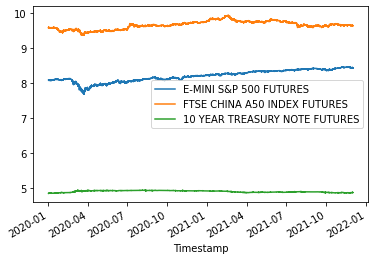

In [21]:
df.set_index('Timestamp').plot()

### Приведение данных к стационарному виду

Приведем данные к стационарному виду и после проверим их на стационарность при помощи теста Дике-Фуллера

(429099, 3)


<AxesSubplot:xlabel='Timestamp'>

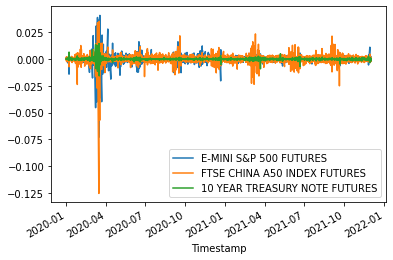

In [22]:
df = df.set_index('Timestamp').diff().dropna()
print(df.shape)
df.plot()


In [23]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
for col in df.columns:
    print('Augmented Dickey-Fuller Test: {}'.format(col))
    augmented_dickey_fuller_statistics(df[col])
    


Augmented Dickey-Fuller Test: E-MINI S&P 500 FUTURES
ADF Statistic: -66.285929
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: FTSE CHINA A50 INDEX FUTURES
ADF Statistic: -65.697262
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: 10 YEAR TREASURY NOTE FUTURES
ADF Statistic: -70.952390
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


## Проверяем общие гипотезы

Сформулируем гипотезы:

Гипотеза 1. Между какой либо парой фьючерсов есть краткосрочная (в минутах) лаговая зависимость на всем периоде данных.

Гипотеза 2. Между какой либо парой фьючерсов есть среднесрочная (в часах) лаговая зависимость на всем периоде данных.

Гипотеза 3. Между какой либо парой фьючерсов есть долгосрочная (в днях или неделях) лаговая зависимость на всем периоде данных.

In [24]:
#просомтрим просто корреляцию
df.corr()

,E-MINI S&P 500 FUTURES,FTSE CHINA A50 INDEX FUTURES,10 YEAR TREASURY NOTE FUTURES
E-MINI S&P 500 FUTURES,1.000000,0.474472,-0.256346
FTSE CHINA A50 INDEX FUTURES,0.474472,1.000000,-0.158448
10 YEAR TREASURY NOTE FUTURES,-0.256346,-0.158448,1.000000


Что бы не принять случайность за лаговую зависимость, при каждом преобразовании таблицы мы будем проводить тест Гренджера. Если p-value пары фьючерсов будет более 0.05, значит данные х не могут быть использованы для предсказания у. Это, возможно позволит сразу отказаться от ненужных проверок. 

In [25]:
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False,maxlag=10):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset

Проверять гипотезы мы будем при помощи Time Lagged Cross Correlation. Если корреляция между фьючерсами при каком-то лаге возрастает, то это сигнал наличия лаговой связи между данными.

Функция печатает график корреляции двух переменных с заданными лагами. 

In [26]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

def print_cc(df, name_one, name_two, lags, show= False):

    d1 = df[name_one]
    d2 = df[name_two]

    rs = [ crosscorr(d1,d2, lag) for lag in range(lags[0],lags[1])]
    
    best_correlation, best_correlation_index = max([abs(i) for i in rs]),[abs(i) for i in rs].index(max([abs(i) for i in rs]))
    if rs[best_correlation_index] <0:
        best_correlation=best_correlation*-1

    offset = np.floor(len(rs)/2)-best_correlation_index
    if show :
        f,ax=plt.subplots(figsize=(14,3))
        ax.plot(rs)
        ax.axvline(len(rs)//2,color='k',linestyle='--',label='Center')
        ax.axvline(best_correlation_index,color='r',linestyle='--',label='Peak synchrony')
        ax.set(title=f'Offset = {offset} frames\n{name_one} leads <> {name_two} leads', xlabel='Offset',ylabel='Pearson r')
        ax.set_xticks([i for i in range(0,lags[1]*2, lags[1]//6)])
        ax.set_xticklabels([i for i in range(lags[0],lags[1], lags[1]//6)]);
        plt.legend()
    return offset, best_correlation


### Гипоетза 1, краткосрочная лаговая зависимость

In [27]:
grangers_causality_matrix(df, variables = ['10 YEAR TREASURY NOTE FUTURES', 'E-MINI S&P 500 FUTURES',
 'FTSE CHINA A50 INDEX FUTURES'])

,10 YEAR TREASURY NOTE FUTURES_x,E-MINI S&P 500 FUTURES_x,FTSE CHINA A50 INDEX FUTURES_x
10 YEAR TREASURY NOTE FUTURES_y,1.0,0.0,0.0
E-MINI S&P 500 FUTURES_y,0.0,1.0,0.0
FTSE CHINA A50 INDEX FUTURES_y,0.0,0.0,1.0


P-value для всех пар меньше 0.05, значит можем смотреть все пары.

In [28]:
def print_all_cc(df, lags =(-150,151) ):
    for pair in [('E-MINI S&P 500 FUTURES', '10 YEAR TREASURY NOTE FUTURES'),
                 ('E-MINI S&P 500 FUTURES', 'FTSE CHINA A50 INDEX FUTURES'),
                 ('10 YEAR TREASURY NOTE FUTURES', 'FTSE CHINA A50 INDEX FUTURES')]:
        print_cc(df, 
                 pair[0], pair[1], 
                 lags= lags, show= True)
    

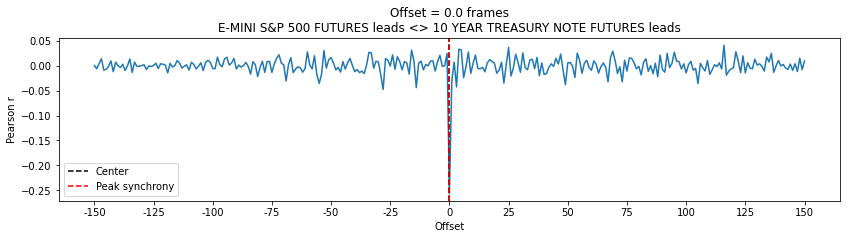

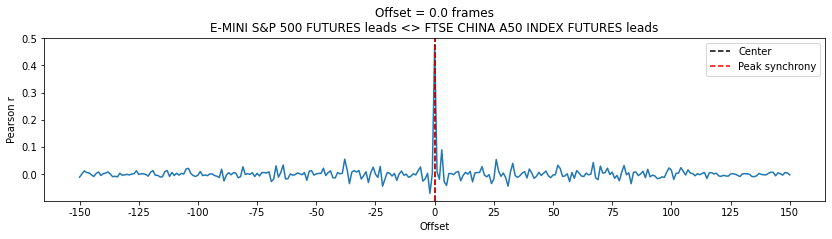

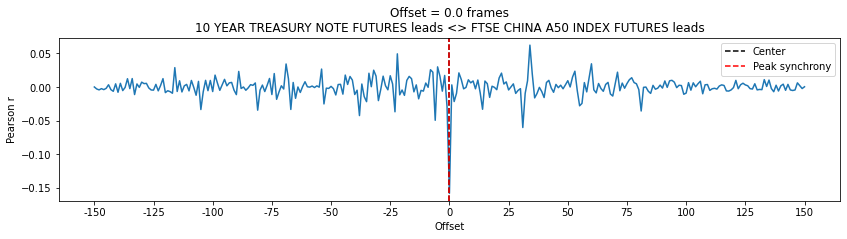

In [29]:
print_all_cc(df)

Мы видим что данные болье всего коррелируют без лага, то есть нет явной лаговой зависимости в периоде 150 минут.

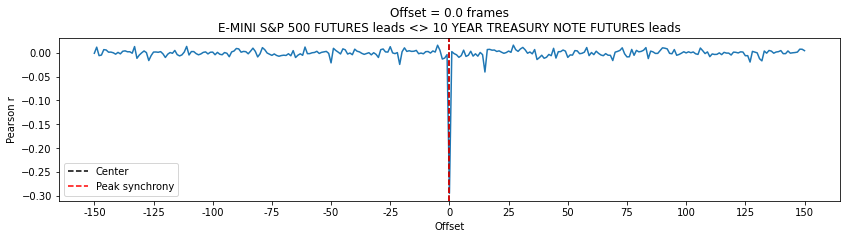

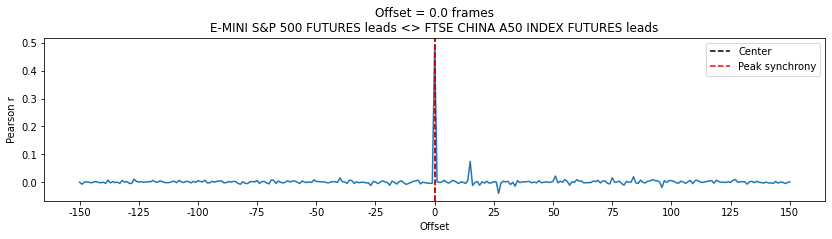

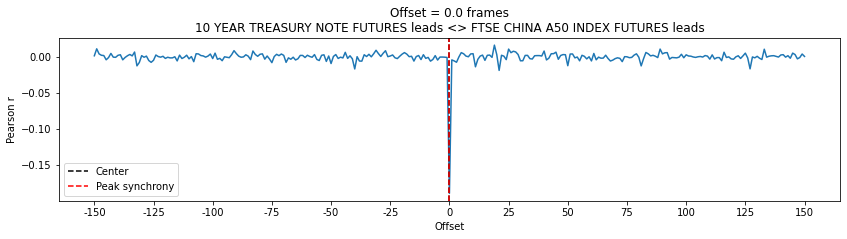

In [30]:
print_all_cc(df.resample('5Min').sum())

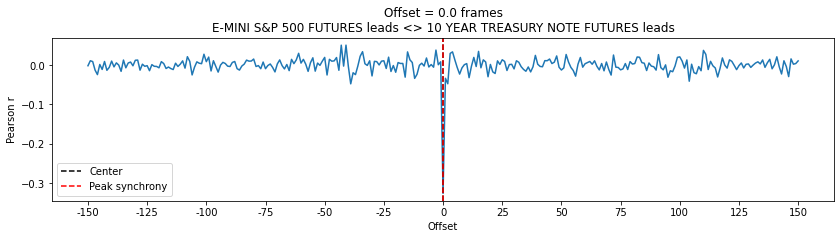

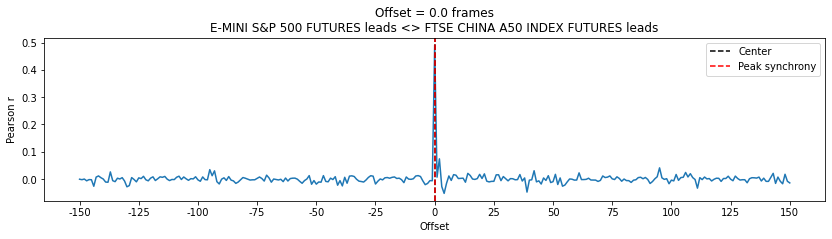

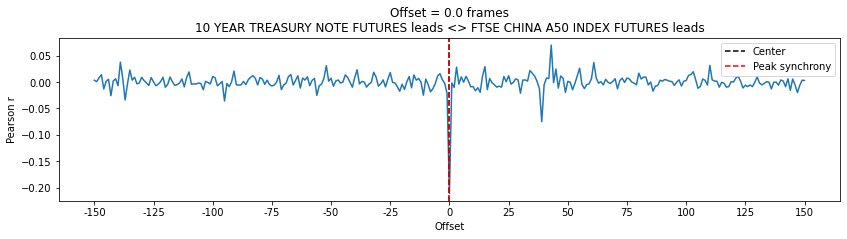

In [31]:
print_all_cc(df.resample('30Min').sum())

При группировке в 5 и 30 минут ситуация не меняется. Таким методом мы не смогли обнаружить краткосрочную лаговую зависимость.

### Среднесрочная лаговая зависимость

In [32]:
grangers_causality_matrix(df.resample('5H').sum(), variables = ['10 YEAR TREASURY NOTE FUTURES', 'E-MINI S&P 500 FUTURES',
 'FTSE CHINA A50 INDEX FUTURES'],maxlag=20)

,10 YEAR TREASURY NOTE FUTURES_x,E-MINI S&P 500 FUTURES_x,FTSE CHINA A50 INDEX FUTURES_x
10 YEAR TREASURY NOTE FUTURES_y,1.0,0.0,0.000
E-MINI S&P 500 FUTURES_y,0.0,1.0,0.401
FTSE CHINA A50 INDEX FUTURES_y,0.0,0.0,1.000


Найденная зависимость между китаем и снп может быть ложной.

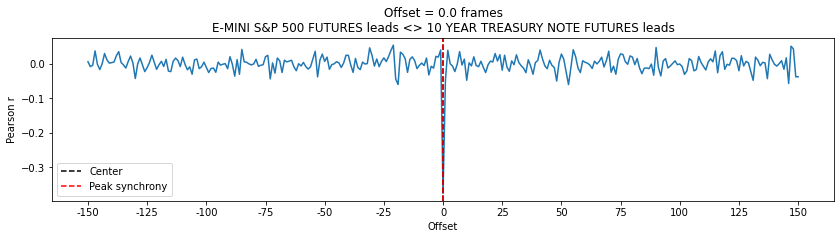

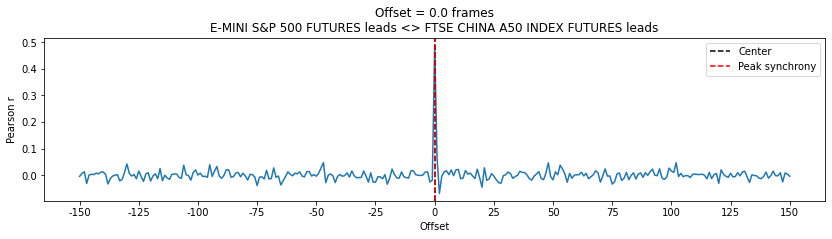

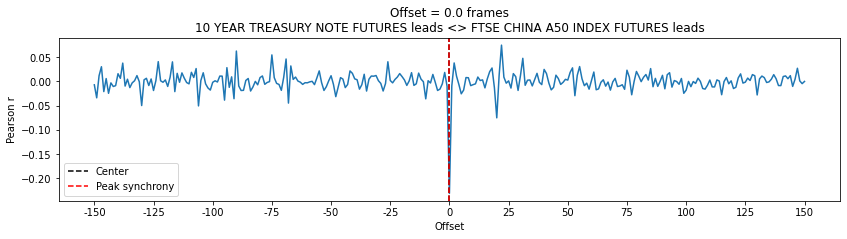

In [33]:
print_all_cc(df.resample('1H').sum())

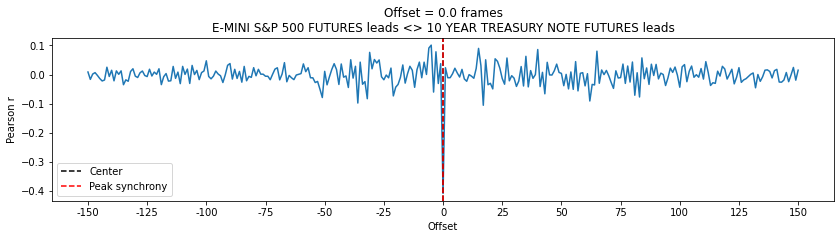

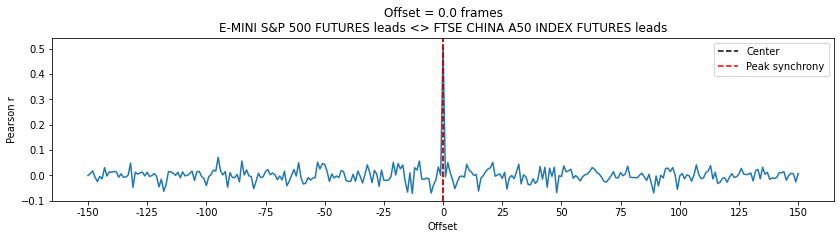

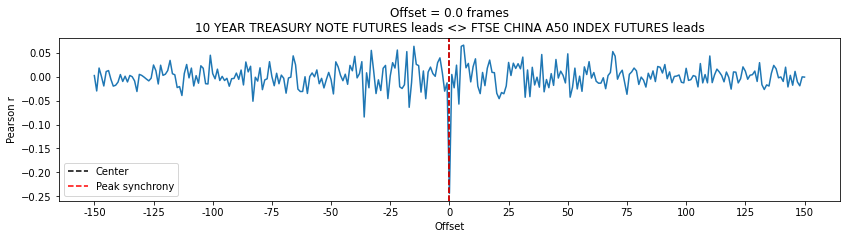

In [34]:
print_all_cc(df.resample('5H').sum())

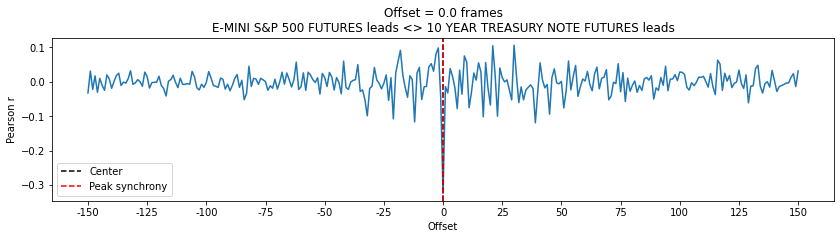

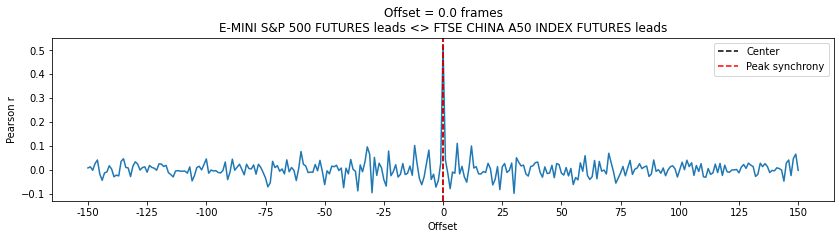

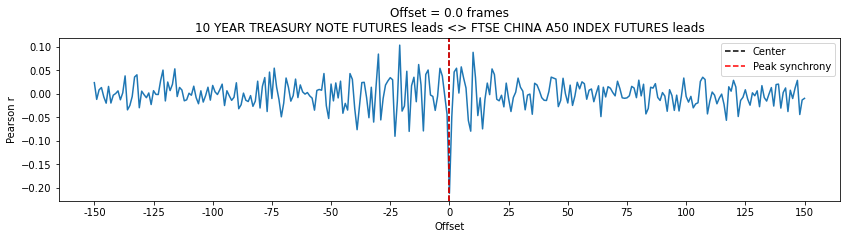

In [35]:
print_all_cc(df.resample('8H').sum())

И здесь мы не нашли явной лаговой зависимости.

### Долгосрочная лаговая зависмость

In [36]:
grangers_causality_matrix(df.resample('1D').sum(), variables = ['10 YEAR TREASURY NOTE FUTURES', 'E-MINI S&P 500 FUTURES',
 'FTSE CHINA A50 INDEX FUTURES'],maxlag=20)

,10 YEAR TREASURY NOTE FUTURES_x,E-MINI S&P 500 FUTURES_x,FTSE CHINA A50 INDEX FUTURES_x
10 YEAR TREASURY NOTE FUTURES_y,1.0000,0.0000,0.0641
E-MINI S&P 500 FUTURES_y,0.0002,1.0000,0.0081
FTSE CHINA A50 INDEX FUTURES_y,0.0071,0.0001,1.0000


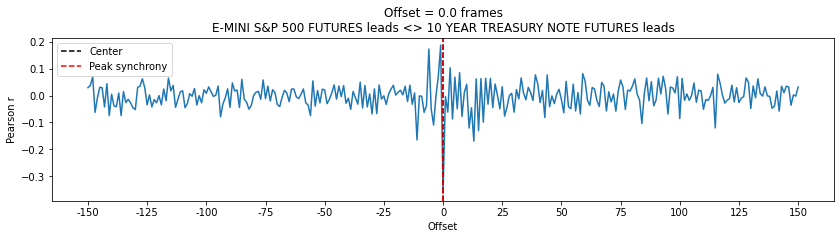

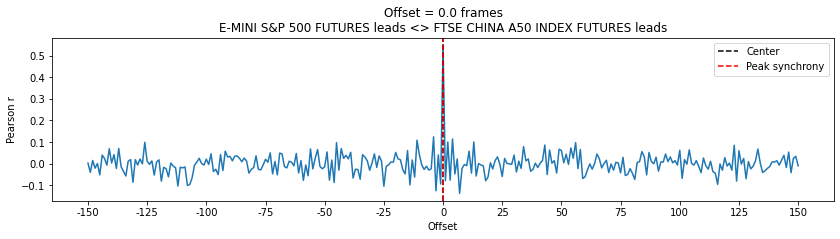

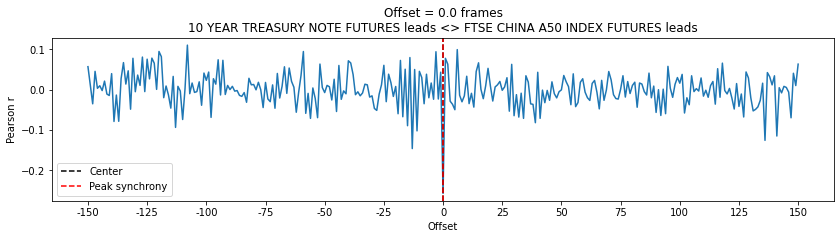

In [37]:
print_all_cc(df.resample('1D').sum())

In [38]:
grangers_causality_matrix(df.resample('1W').sum(), variables = ['10 YEAR TREASURY NOTE FUTURES', 'E-MINI S&P 500 FUTURES',
 'FTSE CHINA A50 INDEX FUTURES'],maxlag=20)

,10 YEAR TREASURY NOTE FUTURES_x,E-MINI S&P 500 FUTURES_x,FTSE CHINA A50 INDEX FUTURES_x
10 YEAR TREASURY NOTE FUTURES_y,1.0000,0.0029,0.0013
E-MINI S&P 500 FUTURES_y,0.0000,1.0000,0.0118
FTSE CHINA A50 INDEX FUTURES_y,0.0021,0.0000,1.0000


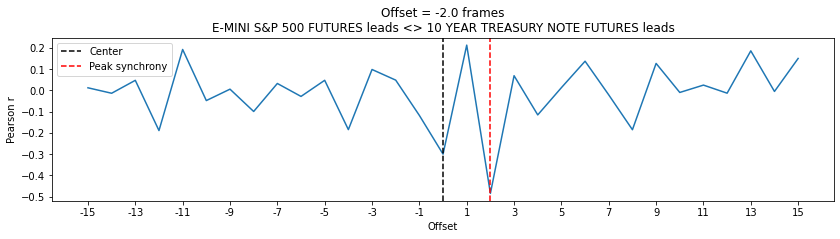

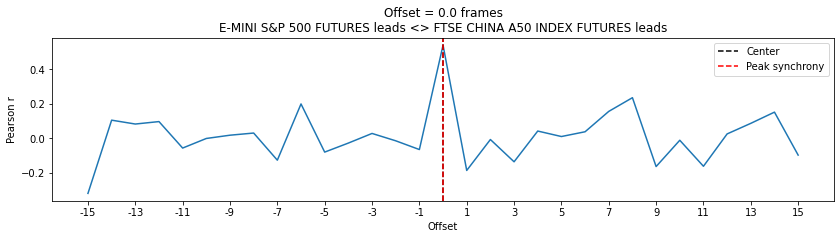

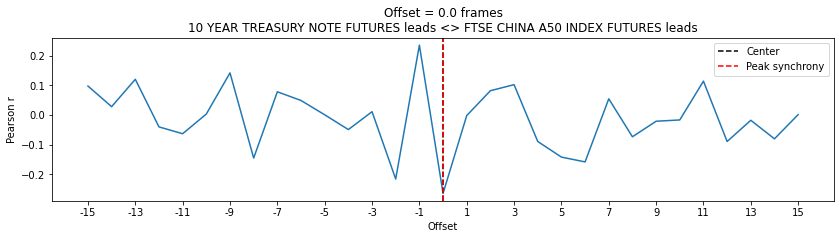

In [39]:
print_all_cc(df.resample('1W').sum(), lags=(-15,16))

 Ура, мы нашли какую-то корреляцию между SnP и 10 летними облигациями.
 10 летние облигации обгоняют snp на 2 недели с отрицательной корреляцией. 
 Иными словами если в эту неделю snp росла, то через 2 недели 10 летние облигации упадут.
 
 Будем дальше проверять эту гипотезу.

## Продолжим анализ найденной закономерности

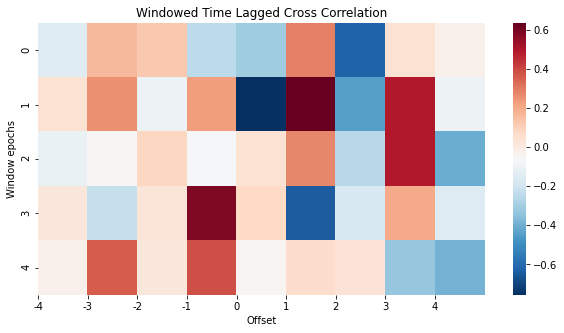

In [40]:
df_test= df.resample('1W').sum()
no_splits = 5
samples_per_split = df_test.shape[0]//no_splits
rss=[]
for t in range(0, no_splits):
    d1 = df_test['E-MINI S&P 500 FUTURES'].reset_index(drop=True).loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = df_test['10 YEAR TREASURY NOTE FUTURES'].reset_index(drop=True).loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-4,5)]
    rss.append(rs)

rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,9], xlabel='Offset',ylabel='Window epochs')
ax.set_xticks([i for i in range(9)])
ax.set_xticklabels([i for i in range(-4,5)]);

Мы снова сгруппировали данные по неделям, разделили все данные на 5 периодов и построили WTLCC матрицу.
Что мы здесь видим. Во первых на протяжении длительного периода есть двухнедельная зависимость между данными фьючерсами (столбик 2). Однако на протяжении времени к наступлению кризиса зависимость затухает и ведущий меняется местами.

На протяжении первых трех периодов есть лаговая зависимость по которой после роста snp через 2 недели падает стоимость 10 летних облигаций. Затем происходят рыночные изменения и постепенно зависимость меняется (на 4 периоде синий квадрат сдвигается и на 5 пропадает, одновременно появляются красные квадраты слева) и наоборот после роста 10 летних облигаций растет стоимость snp.



## Выводы

Мы проанализировали дата сет. Не нашли краткосрочные зависимостей, нашли предположительную недельную лаговую зависимость между двумя индексами
фьючерсами которая со временем изменяется.

Есть много путей для совершенствования поиска лаговой зависимости. 
1) Иная предобработка данных, различные варианты заполнения пропусков 
(скользящее среднее, прошлое значение, прогноз модели и.т.д.) 

2) Можно строить различные модели и искать лаговые закономерности при их помощи.

3) Создавать новые различные признаки и использовать их 

4) Проверить гипотезы с гэпом и разделением задачи на разные периоды

Это требует дополнительного времени